# Assignment 7: Explainable Machine Learing (Part 1)

## Objective:

Interpreting how a machine learning model works is crucial from many aspects, such as debugging the model, improving the model, and derive new insights from the model. There are many model explanation techniques that we can use for interpreting a black box model itself or its predictions. Also, some models are transparent that we can directly get insights from its structure or learned parameters. In this assignment, you are going to train different models on a dataset and try different approaches to explain the model and get some insights. After completing this assignment, you should be able to answer the following questions:

1. How to explain transparent models?
2. How to implement the permutation method to explain black-box models?
3. How to create and interpret partial dependence plots?
4. How to implement the global surrogate method to explain black-box models?
5. How to use SHAP to explain model predictions and interpret its explanation results? 
6. How to use LIME to explain model predictions and  interpret its explanation results? 

The data can be downloaded from [A7-1-data.zip](A7-1-data.zip)



## 0. Preparation

Import relevant libraries and load the dataset:

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import plot

from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

NumExpr defaulting to 8 threads.


The dataset we are going to use is a binary forest covertype dataset and we will predict the forest cover type from cartographic variables only. The first ten features are numerical features, there are also two categorical features in a one-hot encoding fashion (4 and 40 vector length each), the last column is the target forest cover type (binary). More details about the dataset can be found at [https://archive.ics.uci.edu/ml/datasets/covertype](https://archive.ics.uci.edu/ml/datasets/covertype). Please make sure you understand the meaning of each feature.

In [2]:
# load data and take a look at data distribution
data = pd.read_csv('bforest_sample.csv', delimiter=',')
plot(data)


GridBox(id='3146', ...)

In [3]:
# split data into training and test dataset with respect to ratio 0.8:0.2
train, test = train_test_split(data, test_size=0.2, random_state=733)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
feature_names = list(X_train)

# rescale
scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=feature_names)



## Task 1. Transparent Model

In this task, you are going to train a logistic regression model and interpret it. For logistic regression, since the effect of each feature is simply added together, we can interpret it directly by looking at the coefficient of each feature. Please follow the comment to finish the code:

In [4]:
# train a logistic regression model
lr = LogisticRegression().fit(X_train, y_train)

D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [5]:
# set default figure size
plt.rcParams['figure.figsize'] = [16, 8]

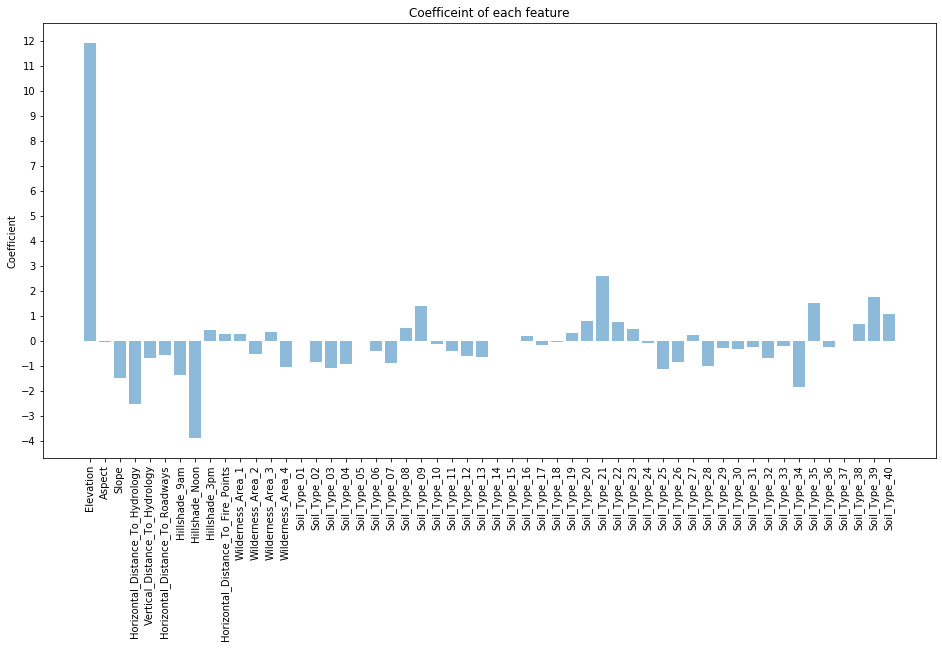

In [6]:
# show the coefficient value for each feature by a bar chart
import math
def explain_logistic_regression(lr, feature_names):
    # --- Write your code below ---
    feature = feature_names
    y_pos = np.arange(len(feature))
    coeff = lr.coef_[0]

    plt.bar(y_pos, coeff, align='center', alpha=0.5)
    plt.xticks(y_pos, feature)
    plt.ylabel('Coefficient')
    plt.title('Coefficeint of each feature')
    plt.xticks(rotation=90)

    plt.yticks(np.arange(math.ceil(min(coeff))-1, max(coeff)+1, 1.0))

    plt.show()
# explain the model
explain_logistic_regression(lr, feature_names)

For a specific prediction, we can get a more concrete effect of each feature by the product of the coefficient and input feature value. Please follow the comment to finish the code:

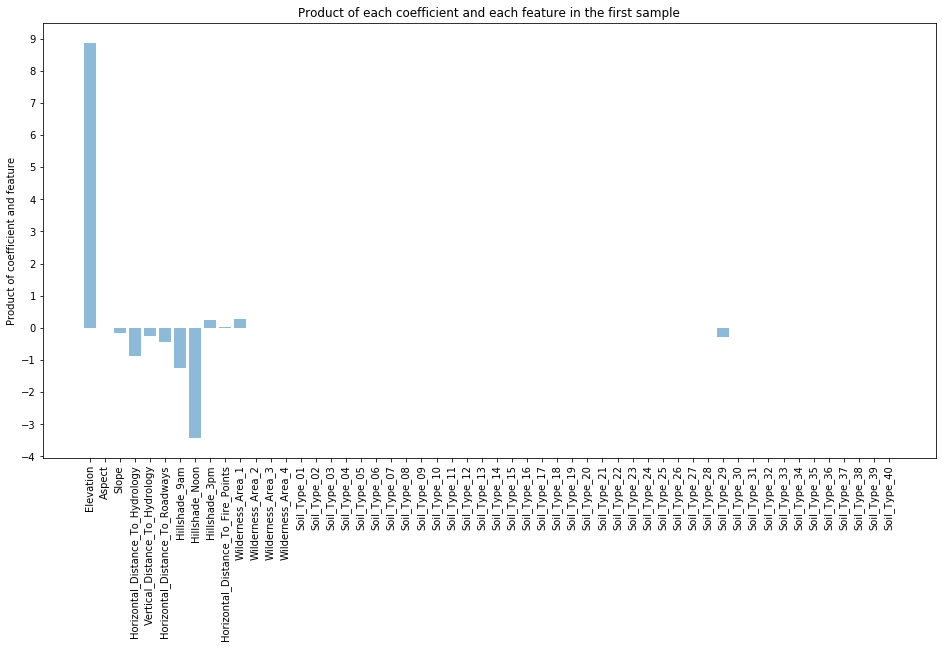

Covertype:  0


In [7]:
# show the effect from each input feature by a bar chart
def explain_logistic_regression_prediction(lr, feature_names, sample):
    # --- Write your code below ---
#     print(sample[0])
    list_input = [x for x in sample[0]]
    list_coeff = lr.coef_[0]
    product_input_coeff = np.multiply(list_input,list_coeff)
    
    feature = feature_names
    y_pos = np.arange(len(feature))

    plt.bar(y_pos, product_input_coeff, align='center', alpha=0.5)
    plt.xticks(y_pos, feature)
    plt.ylabel('Product of coefficient and feature')
    plt.title('Product of each coefficient and each feature in the first sample')
    plt.xticks(rotation=90)

    plt.yticks(np.arange(math.ceil(min(product_input_coeff))-1, max(product_input_coeff)+1, 1.0))

    plt.show()
    
explain_logistic_regression_prediction(lr, feature_names, (X_test.iloc[0, :], y_test.iloc[0]))
print("Covertype: ", y_test.iloc[0])

What can you get from the above plots? Please write down two findings:

**Findings:**
1. From the product of the first test data and coefficient in our Logistic Regression model, we can see that there are two feature bars('Elevation and Hill_shadenoon') which are strikingly greater than any other feature bars.  We can interpret that, for the first test data, the possible effects for 'Elevation' and 'Hill_shadenoon' are greater than the effect for any of the other features (even though they have opposite direction: positive and negative).
2. For the first test data, the product between data and coefficient of 'Elevation' is very high and positive. With 'Elevation' being numerical variable and test Cover type being '0' Type, the positive product tells us that the forest with high 'Elevation' is likely to have Cover type '0'. 

## Task 2. Post-hoc Explanation (Global Model)

In this task, you are going to build a gradient boosting tree model and a neural network, and use some techniques we introduced in class to interpret these models. First, let's train the models using training data:

In [8]:
# train a gradient boosting classifier
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [9]:
# train a multi-layer perceptron classifier
mlp = MLPClassifier(learning_rate_init=0.1).fit(X_train, y_train)

### 2.1 Permutation

In [10]:
# get importance score (E' - E) for each feature by permutation, use log_loss as error
from sklearn.metrics import log_loss
# from sklearn.inspection import permutation_importance


def permutation_importance(model, feature_names, X, y):
    # calculate importance score for each feature by purmutation approach
    # --- Write your code below ---
    
    def shuffle_each_column(x):
        p = x.shape[1]
        for i in range(p):
            hold = np.array(x[:,i])
            np.random.shuffle(x[:,i])
            yield x
            x[:,i] = hold

    list_feature_shuffle= []

    for X_shuffle in shuffle_each_column(X):
        model_predict = model.predict(X_shuffle)
        log_loss_each_feature = log_loss(model_predict,y)
        list_feature_shuffle.append(log_loss_each_feature)
    
    X_log_loss = log_loss(model.predict(X),y)
    list_feature_importance = np.asarray(list_feature_shuffle)- X_log_loss
    print(list_feature_importance)
    
#     print(permutation_importance(model,feature_names,X,y))
    
    # show the top 5 most important features
    # --- Write your code below ---
    index_top5_feature = np.argsort(list_feature_importance)[::-1][:5]
    print("indexes of top5 feature importance: ",index_top5_feature)
    top5_feature_name = [feature_names[index] for index in index_top5_feature]
    print("names of top5 feature importance: ",top5_feature_name)
    print('\n')
permutation_importance(gb, feature_names, X_test.to_numpy(), y_test.to_numpy())
permutation_importance(mlp, feature_names, X_test.to_numpy(), y_test.to_numpy())

[ 8.41244094e+00 -3.48633578e-03 -3.48778915e-03  5.40601909e-01
  2.79032821e-02  7.81252175e-01  9.06810646e-02  5.16186658e-01
 -6.97549757e-03  1.67411215e-01 -5.65200647e-07  2.09264927e-02
  3.13901024e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.04625600e-02  3.48770841e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.01144674e-01  1.04632867e-02  2.89481574e-01
  1.70903283e-01  6.97549757e-03  6.97541682e-03  0.00000000e+00
  1.74386228e-02  0.00000000e+00  2.09267349e-02  3.48770841e-03
  1.04632060e-02  1.04611874e-02 -1.74386228e-02  1.04632867e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.04628830e-02
  5.92904778e-02  0.00000000e+00]
indexes of top5 feature importance:  [ 0  5  3  7 35]
names of top5 feature importance:  ['Elevation', 'Horizontal_Distan

### 2.2 Partial dependence plots

In this section, you are going to use the [plot_partial_dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence) provided by sklearn to see the marginal effect of each single numerical features:

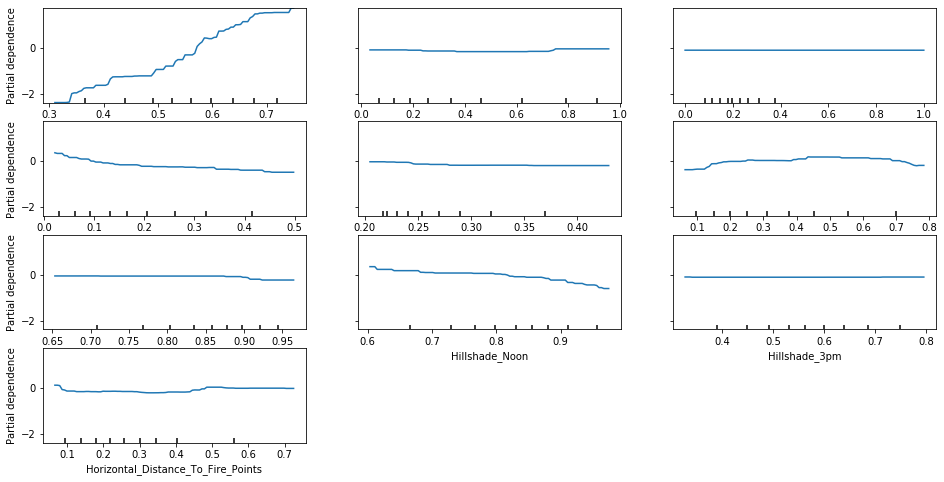

In [11]:
# plot partial dependence for numerical features (first 10 features) for gradient boosting classifier
# --- Write your code below ---
from sklearn.inspection import plot_partial_dependence
gb_plot = plot_partial_dependence(gb, X_train,feature_names[:10]) 

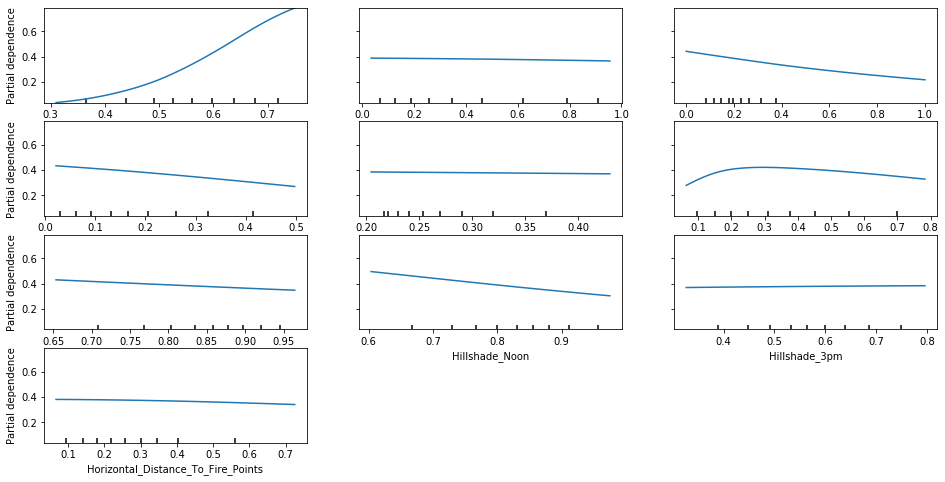

In [12]:
# plot partial dependence for numerical features (first 10 features) for neural network
# --- Write your code below ---
gb_plot = plot_partial_dependence(mlp, X_train,feature_names[:10]) 

### 2.3 Global Surrogate

Now, let's train a simple logistic regression based on the gradient boosting tree model and neural network we built before. And use the method we implemented previously to interpret the derived transparent model:

D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressio

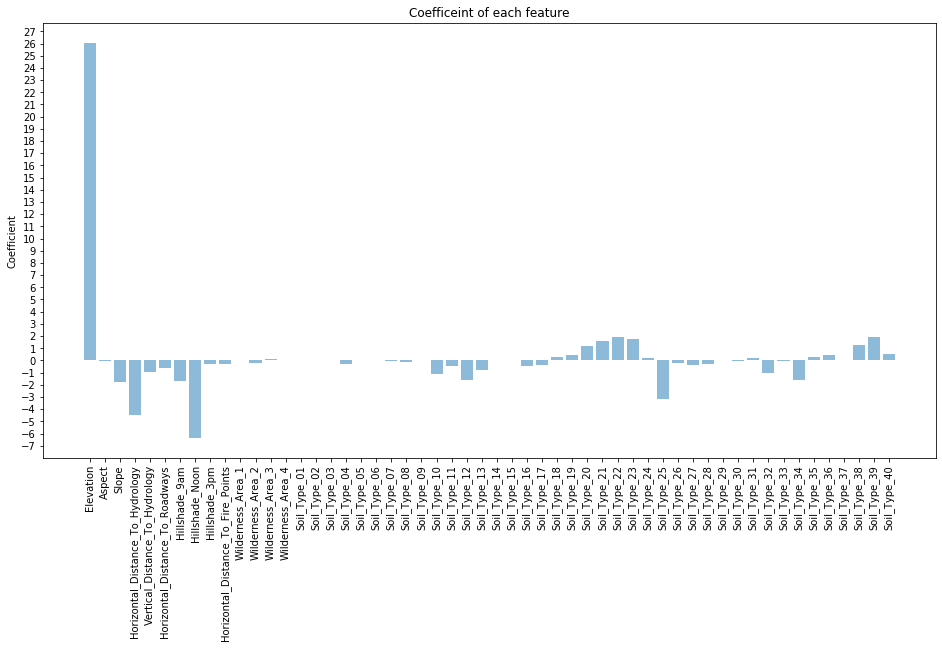

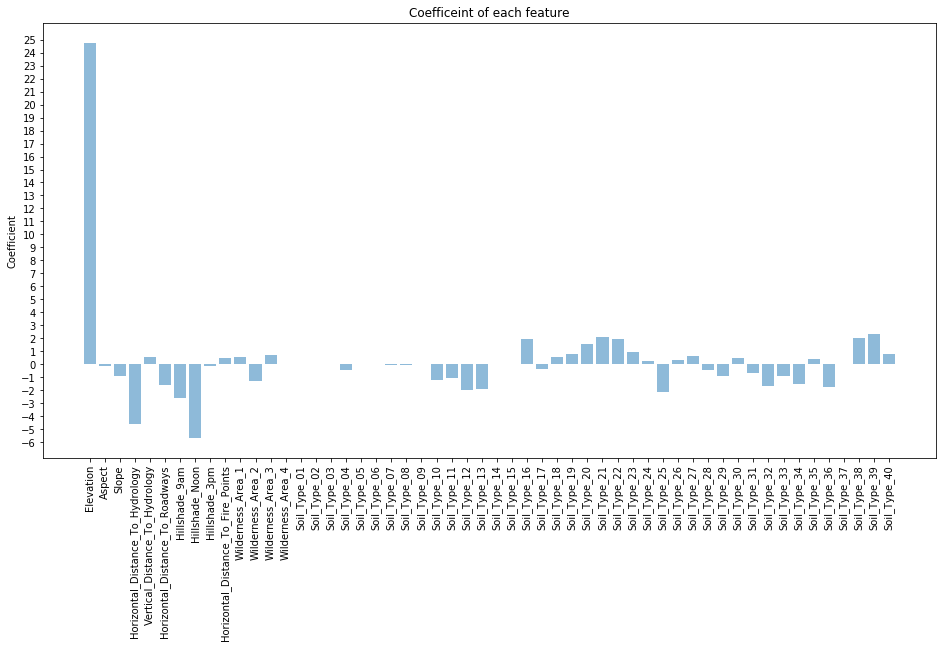

In [13]:
# train a logistic regression model on gb and mlp and explain using explain_logistic_regression()

# --- Write your code below ---
gb_predict = gb.predict(X_test)
mlp_predict = mlp.predict(X_test)

lr_gb = LogisticRegression().fit(X_test, gb_predict)
lr_mlp = LogisticRegression().fit(X_test, mlp_predict)

explain_logistic_regression(lr_gb, feature_names)
explain_logistic_regression(lr_mlp, feature_names)

## Task 3. Post-hoc Explanation (Single Prediction)

### 3.1 Attribution

From now, let's focus on interpreting single predictions. [SHAP](https://github.com/slundberg/shap) is an efficient method to approximatly calculate the shapely value we mentioned in class. Please install the library and take a look at the doc. Explain the first prediction made by the gradient boosting tree model in the test set:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.
The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.


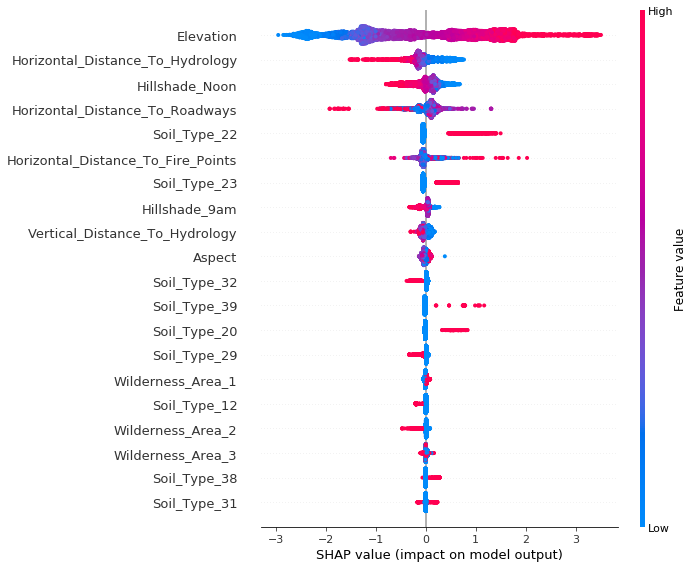

In [14]:
import shap

# load JS visualization code to notebook
shap.initjs()

# use Tree SHAP explainer to explain the gradient boosting tree model
# you only need to explain and plot the first explaination
# --- Write your code below ---
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
display(shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:]))

# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], link="logit")
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names)

What can you get from the above representation? Please write down two findings:

**Findings:**
1. For the first plot, features pushing the prediction higher are shown in red while those pushing the prediction lower are in blue. In addition, their visual size shows the magnitude of the feature's effect. We predicted 0.17, whereas the base_value is -0.4003. The biggest impact comes from 'Elevation' being 0.7445. Though 'Soil_Type_29' and 'Horizontal_Distance_To_Roadways' value have a meaningful effect decreasing the prediction.
2. For the second plot, the plot shows the SHAP values of every feature for every test data we put in. This shows the SHAP values on the x-axis. All the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. For example, positive high 'Elevation' has very high positive relationship with CoverType. 

### 3.2 LIME

[LIME](https://github.com/marcotcr/lime) is a library implemented by the authors of the paper. Please install the library and take a look at the doc and tutorial. Use it to explain the first prediction made by the neural network model in the test set:

In [15]:
from lime import lime_tabular
import sklearn
import lime

# use LimeTabularExplainer to explain the neural network model
# you only need to explain and plot the first explaination
# --- Write your code below ---
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,class_names=['0','1'], feature_names=feature_names)
exp = explainer.explain_instance(X_test.values[0], mlp.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook(show_table=True, show_all=False)


Run LIME multiple times, (Q1) what do you think of the stability of LIME? (Q2) Can you briefly explain the reason?

**Your Answer:** 
1. For the first data in our test dataset, the predicted value for Forest CoverType is '1' with probability equal to 0.63 while CoverType '0' is 0.37. Each feature’s contribution to this '1' prediction is shown in the right bar plot (Orange). 
2. Orange signifies the positive impact and blue signifies the negative impact of that feature on the CoverType '1'. On the other hand, orange signifies the negative impact and blue signifies the positive impact of that feature on the CoverType '0'.


## Submission
Complete the code in this notebook, and submit it to the CourSys activity Assignment 7.